In [1]:
import scanpy as sc
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import skimage.io as io
import random
from torch_geometric.data import Data

In [2]:
torch.cuda.is_available()

True

In [3]:
import numpy as np

def extract_patches(image, cell_coords, patch_size=100):
    """
    Extract image patches centered on given cell coordinates.

    Parameters:
    image (numpy.ndarray): The input image from which patches are to be extracted.
    cell_coords (list of tuples): A list of (x, y) coordinates around which patches are to be extracted.
    patch_size (int, optional): The size of the square patches to be extracted. Default is 100.

    Returns:
    list of numpy.ndarray: A list of extracted image patches, all of the same size.

    Notes:
    - If a patch extends beyond the image border, it will be padded with zeros to match the specified patch size.
    """
    patches = []
    half_size = patch_size // 2
    h, w = image.shape[:2]
    different_shape_count = 0

    # Ensure the input image has 3 dimensions
    if len(image.shape) == 2:  # Grayscale image
        image = image[:, :, np.newaxis]

    for (x, y) in cell_coords:
        x, y = int(x), int(y)
        x_min, x_max = x - half_size, x + half_size
        y_min, y_max = y - half_size, y + half_size

        # Initialize the patch with zeros
        patch = np.zeros((patch_size, patch_size, image.shape[2]), dtype=image.dtype)

        # Calculate bounds for extracting the region from the image
        x_start = max(0, x_min)
        x_end = min(w, x_max)
        y_start = max(0, y_min)
        y_end = min(h, y_max)

        # Calculate where to place the extracted region in the patch
        patch_x_start = max(0, -x_min)
        patch_x_end = patch_x_start + (x_end - x_start)
        patch_y_start = max(0, -y_min)
        patch_y_end = patch_y_start + (y_end - y_start)

        # Assign the extracted region into the patch
        patch[patch_y_start:patch_y_end, patch_x_start:patch_x_end] = image[y_start:y_end, x_start:x_end]

        if patch.shape[:2] != (patch_size, patch_size):
            different_shape_count += 1

        patches.append(patch)

    print(f"Number of patches with different shapes before padding: {different_shape_count}")
    return patches


In [4]:
def seed_everything(seed=0):
    """Initialize random seeds for reproducibility."""
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    
# Set random seed for reproducibility
random_seed = 0
seed_everything(random_seed)

# Data Preparation

In [5]:
file_dir = "st_project/cellbin_analysis/spatial_variation/wx_data/"  # Directory containing the data files
files = os.listdir(file_dir)  # List all files in the directory
files = [i for i in files if i.endswith(".h5ad") and "month" in i]  # Filter files to include only those ending with ".h5ad" and containing "month"
file_paths = [os.path.join(file_dir, i) for i in files]  # Create full file paths for the filtered files
adatas = {}  # Initialize an empty dictionary to store AnnData objects

# Read each file and store the AnnData object in the dictionary
for i in range(len(file_paths)):
    adatas[files[i].split(".")[0]] = sc.read(file_paths[i])

# Preprocess each AnnData object
for key in adatas.keys():
    sc.pp.normalize_total(adatas[key], target_sum=1e4)  # Normalize counts per cell
    sc.pp.log1p(adatas[key])  # Logarithmize the data
    sc.pp.scale(adatas[key])  # Scale the data to unit variance

In [6]:
# Extract spatial coordinates for each cell
cell_coords = {}
for key in adatas.keys():
    cell_coords[key] = adatas[key].obsm["spatial"].copy()
    
# Calculate the neighborhood graph
for key in adatas.keys():
    sc.pp.neighbors(adatas[key], n_neighbors=15, use_rep="spatial", random_state=random_seed)
    
# Extract the spatial neighbors
neighbors = {}
for key in adatas.keys():
    neighbors[key] = adatas[key].obsp["connectivities"].copy()

In [7]:

# Load the plaque dataset
img_dir = "st_project/cellbin_analysis/spatial_variation/wx_data/protein_seg_result/"
img_files = os.listdir(img_dir)
img_files = [i for i in img_files if i.endswith(".tiff") and "plaque" in i]
# Read the images

imgs = {}
for i in range(len(img_files)):
    imgs[img_files[i].split(".")[0]] = io.imread(os.path.join(img_dir, img_files[i]))
imgs.keys()
# Rename the imgs to match the adata keys
for key in list(imgs.keys()):
    parts = key.split("_")
    if len(parts) > 1:
        new_key = parts[1] + "_" + parts[2]
        imgs[new_key] = imgs.pop(key)



In [8]:
# Extract patches from the images
patches = {}
for key in imgs.keys():
    patches[key] = extract_patches(imgs[key], cell_coords[key], patch_size=128)

# Extract the positive patches
positive_patches = {}
for key in patches.keys():
    pos_list = []
    for i in range(len(patches[key])):
        if np.sum(patches[key][i]) > 0:
            pos_list.append(patches[key][i])
    positive_patches[key] = pos_list

# Convert the patches to binary and calculate the area of positive pixels for each patch
binary_patches = {}
for key in patches.keys():
    binary_patches[key] = [patch > 0 for patch in patches[key]]
# Calculate the area of positive pixels for each patch
areas = {}
for key in binary_patches.keys():
    areas[key] = [np.sum(patch) for patch in binary_patches[key]]

Number of patches with different shapes before padding: 0
Number of patches with different shapes before padding: 0
Number of patches with different shapes before padding: 0
Number of patches with different shapes before padding: 0


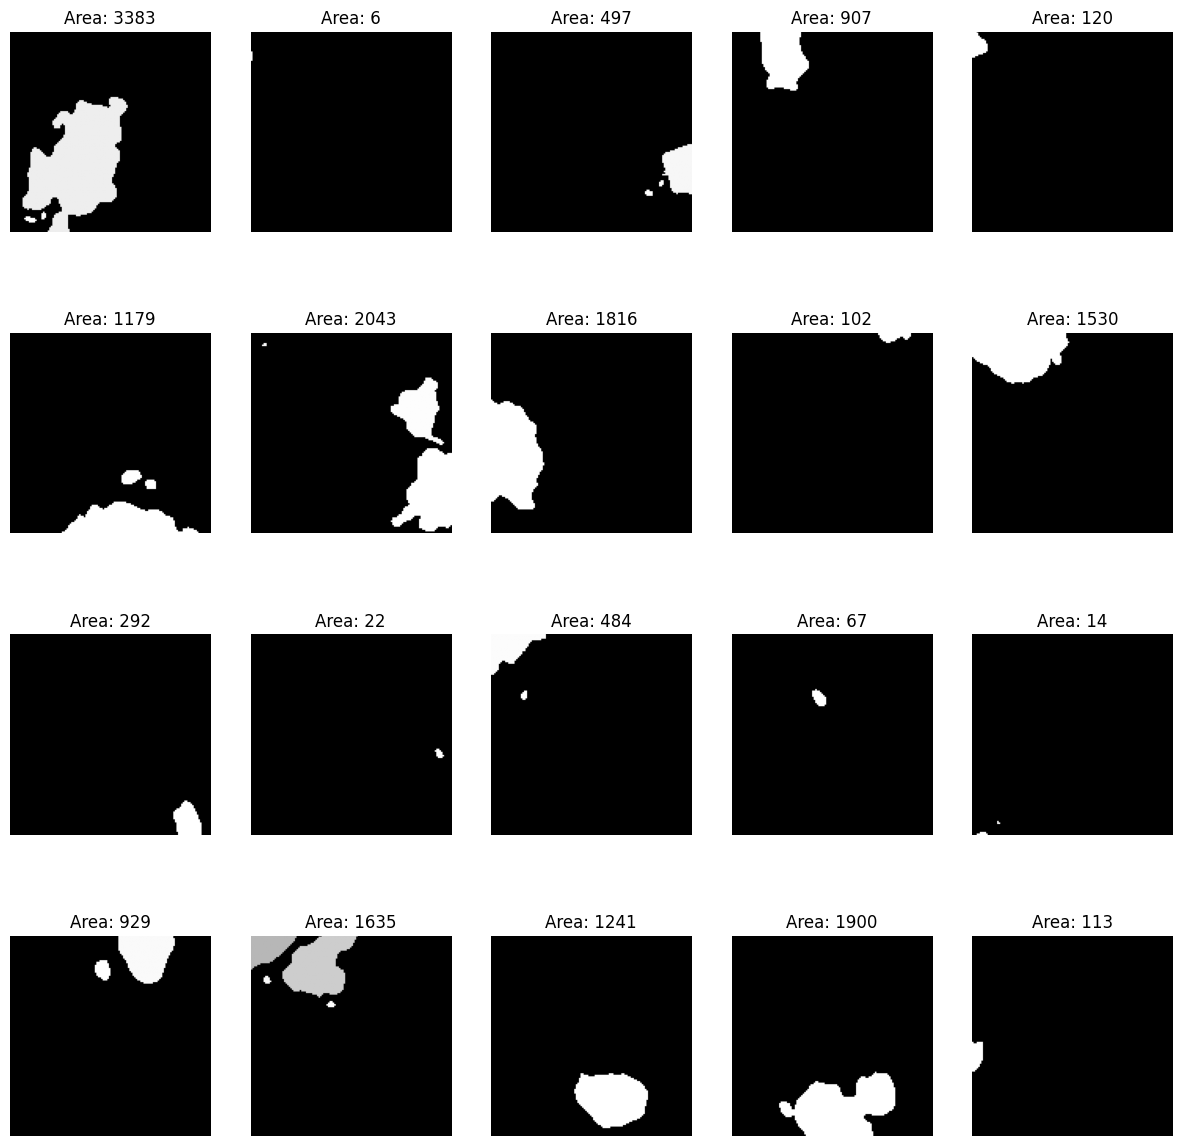

In [9]:
# Choose 5 patches with non-zero area for each image and plot them
import matplotlib.pyplot as plt

# Set the number of patches to plot
n_patches = 5

# Plot the patches
fig, axes = plt.subplots(nrows=len(areas), ncols=n_patches, figsize=(15, 15))
axes = np.atleast_2d(axes)  # Ensure axes is 2D for consistent indexing

for i, key in enumerate(areas.keys()):
    non_zero_indices = np.where(np.array(areas[key]) > 0)[0]
    chosen_indices = random.sample(list(non_zero_indices), n_patches)
    for j, idx in enumerate(chosen_indices):
        axes[i, j].imshow(patches[key][idx], cmap="gray")
        axes[i, j].set_title(f"Area: {areas[key][idx]}")
        axes[i, j].axis("off")
    axes[i, 0].set_ylabel(key, rotation=0, size="large", labelpad=50)

## Graph Construction

In [10]:
import torch
import scipy.sparse
from torch_geometric.data import Data
import numpy as np
from tqdm import tqdm

def create_graph_data_dict(adatas, areas, neighbors, cell_coords):
    """
    Create a dictionary of PyTorch Geometric Data objects from AnnData objects.
    
    Parameters:
    - adatas: dict of AnnData objects
    - areas: dict of patch areas
    - neighbors: dict of connectivity matrices
    - cell_coords: dict of spatial coordinates
    
    Returns:
    - graph_data_dict: dict of PyTorch Geometric Data objects
    """
    graph_data_dict = {}

    for key in tqdm(adatas.keys(), desc="Creating graph data"):
        # Ensure the keys match between adata and patches
        if key not in areas:
            print(f"Warning: No patch area data for {key}. Skipping.")
            continue

        adata = adatas[key]
        num_cells = adata.n_obs

        # Features: Gene expression data
        # Assuming 'X' is already a NumPy array after preprocessing
        features = adata.X
        if isinstance(features, scipy.sparse.csr_matrix):
            features = features.toarray()
        features = torch.tensor(features, dtype=torch.float)

        # Labels: Patch areas
        label_areas = areas[key]
        if len(label_areas) != num_cells:
            print(f"Warning: Number of patches and cells do not match for {key}.")
            # Handle mismatch, e.g., by trimming or padding
            min_len = min(len(label_areas), num_cells)
            label_areas = label_areas[:min_len]
            features = features[:min_len]

        labels = torch.tensor(label_areas, dtype=torch.float).unsqueeze(1)  # Shape: [num_nodes, 1]

        # Edges: Connectivity matrix
        connectivity = neighbors[key].tocoo()

        # Efficiently convert the edge matrix to tensor
        edge_index = torch.tensor(np.vstack([connectivity.row, connectivity.col]), dtype=torch.long)

        # Create PyTorch Geometric Data object
        data = Data(x=features, edge_index=edge_index, y=labels)

        # Optionally, add additional information (e.g., spatial coordinates)
        # spatial = torch.tensor(cell_coords[key], dtype=torch.float)
        # data.pos = spatial

        # Add to the dictionary
        graph_data_dict[key] = data

    return graph_data_dict


# Create the graph dictionary
graph_data_dict = create_graph_data_dict(adatas, areas, neighbors, cell_coords)


# Efficiently convert patches to tensors in batch
for key, graph in tqdm(graph_data_dict.items(), desc="Adding patches to graph data"):
    # Ensure patches[key] is a list of NumPy arrays
    patches_tensor = torch.tensor(np.array(patches[key]), dtype=torch.float)  # Convert patches to a single tensor efficiently
    graph.patches = patches_tensor



Adding patches to graph data: 100%|██████████| 4/4 [00:00<00:00,  5.87it/s]


In [11]:
graph_data_dict

{'8months-disease-replicate_1': Data(x=[8186, 2766], edge_index=[2, 131356], y=[8186, 1], patches=[8186, 128, 128, 1]),
 '13months-disease-replicate_1': Data(x=[10372, 2766], edge_index=[2, 167278], y=[10372, 1], patches=[10372, 128, 128, 1]),
 '8months-disease-replicate_2': Data(x=[8202, 2766], edge_index=[2, 132328], y=[8202, 1], patches=[8202, 128, 128, 1]),
 '13months-disease-replicate_2': Data(x=[9634, 2766], edge_index=[2, 155576], y=[9634, 1], patches=[9634, 128, 128, 1])}

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
device

device(type='cuda')

In [14]:
# Check system's gpu info
!nvidia-smi


Tue Dec 24 16:20:01 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.216.03             Driver Version: 535.216.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA H100 PCIe               Off | 00000000:1F:00.0 Off |                    0 |
| N/A   31C    P0              51W / 350W |      5MiB / 81559MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [15]:
torch.version.cuda

'12.4'

# Prediction & Represenation of the graph

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, SAGEConv, GATConv, global_mean_pool


In [41]:
test_replicate_name = '13months-disease-replicate_2'


In [42]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_val_datalist = []
test_data = None

for name, raw_data in graph_data_dict.items():
    data = raw_data.clone()
    data.y = (data.y > 0).float()  # Binarize

    if name == test_replicate_name:
        # This entire graph is our final test set.
        test_data = data
    else:
        # We do random node-level splits for training & validation
        num_nodes = data.x.size(0)
        perm = torch.randperm(num_nodes)

        train_cutoff = int(0.8 * num_nodes)
        val_cutoff   = int(0.9 * num_nodes)

        data.train_idx = perm[:train_cutoff]
        data.val_idx   = perm[train_cutoff:val_cutoff]
        data.mini_test_idx = perm[val_cutoff:]  # optional mini-test

        train_val_datalist.append(data)

# Move test_data to device
test_data = test_data.to(device)


In [43]:
class GNNClassifier(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels=1, residual=True, dropout=0.5):
        super().__init__()
        
        # -- GCN Layer --
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.bn1 = nn.BatchNorm1d(hidden_channels)
        
        # -- GraphSAGE Layer --
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.bn2 = nn.BatchNorm1d(hidden_channels)

        # Optional skip connection parameter
        self.residual = residual

        # -- Final MLP block --
        self.mlp = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_channels, out_channels)
        )
        
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index, batch=None):
        # --- First layer: GCN ---
        out1 = self.conv1(x, edge_index)
        out1 = self.bn1(out1)
        out1 = F.relu(out1)
        out1 = self.dropout(out1)
        
        # --- Second layer: GraphSAGE ---
        out2 = self.conv2(out1, edge_index)
        out2 = self.bn2(out2)
        out2 = F.relu(out2)
        out2 = self.dropout(out2)
        
        # --- Residual Connection (optional) ---
        if self.residual:
            out2 = out1 + out2  # Skip connection

        # If graph-level classification, you'd pool here:
        #   out2 = global_mean_pool(out2, batch)
        # But for node-level, we skip global pooling.

        # --- Final MLP (per node) ---
        out = self.mlp(out2)

        return out


In [44]:
def weights_init(m):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)


criterion = nn.BCEWithLogitsLoss()

def train_classifier(model, optimizer, datalist):
    """ Train on the 'train_idx' of each graph in datalist. """
    model.train()
    optimizer.zero_grad()
    total_loss = 0.0
    
    for data in datalist:
        data = data.to(device)
        out = model(data.x, data.edge_index).squeeze()  # shape: [num_nodes]
        
        train_labels = data.y[data.train_idx].view(-1)
        train_preds  = out[data.train_idx]              # shape: [num_train_nodes]
        
        loss = criterion(train_preds, train_labels)
        loss.backward()
        total_loss += loss.item()
    
    # Single optimizer step for all graphs combined
    optimizer.step()
    return total_loss / len(datalist)


@torch.no_grad()
def evaluate_classifier(model, datalist, split="val_idx"):
    """
    Evaluate the model on the given split of each graph in datalist.
    Return average (loss, accuracy, AUC) across all graphs.
    """
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_nodes   = 0
    all_labels    = []
    all_scores    = []
    
    for data in datalist:
        data = data.to(device)
        out = model(data.x, data.edge_index).squeeze()
        
        idx = getattr(data, split)  # e.g. data.val_idx
        labels = data.y[idx].view(-1)
        preds  = out[idx]
        
        # BCEWithLogitsLoss
        loss = criterion(preds, labels)
        total_loss += loss.item()
        
        # Accuracy
        prob = torch.sigmoid(preds)
        binary_pred = (prob > 0.5).float()
        correct = (binary_pred == labels).sum().item()
        
        total_correct += correct
        total_nodes   += len(labels)
        
        # For AUC
        all_labels.append(labels.cpu())
        all_scores.append(prob.cpu())
    
    avg_loss = total_loss / len(datalist)
    avg_acc  = total_correct / total_nodes
    
    # Compute AUC across all graphs combined
    all_labels = torch.cat(all_labels, dim=0).numpy()
    all_scores = torch.cat(all_scores, dim=0).numpy()
    try:
        auc = roc_auc_score(all_labels, all_scores)
    except ValueError:
        # If all labels are 0 or 1, AUC can be undefined
        auc = float('nan')
    
    return avg_loss, avg_acc, auc


In [45]:
in_channels = train_val_datalist[0].x.size(1)

pre_model = GNNClassifier(
    in_channels=in_channels,
    hidden_channels=128,
    dropout=0.6
).to(device)

pre_model.apply(weights_init)

optimizer = torch.optim.Adam(pre_model.parameters(), lr=0.0001)


Training on multiple graphs:   0%|          | 0/1000 [00:00<?, ?it/s]

Best validation accuracy: 0.9249


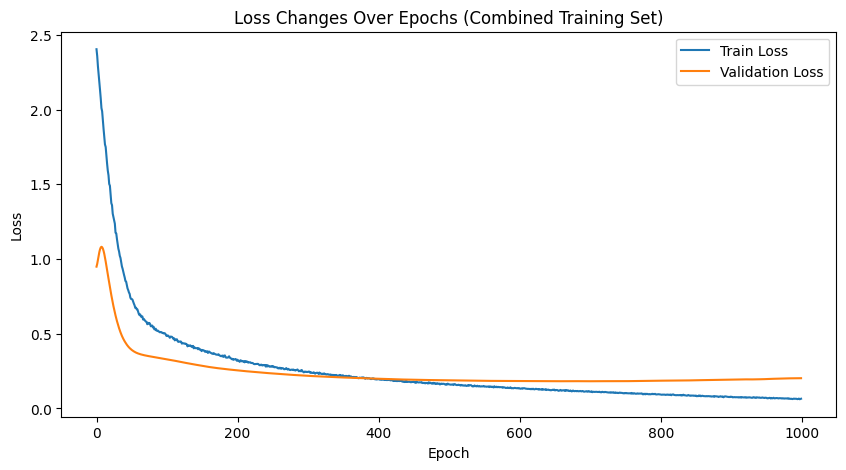

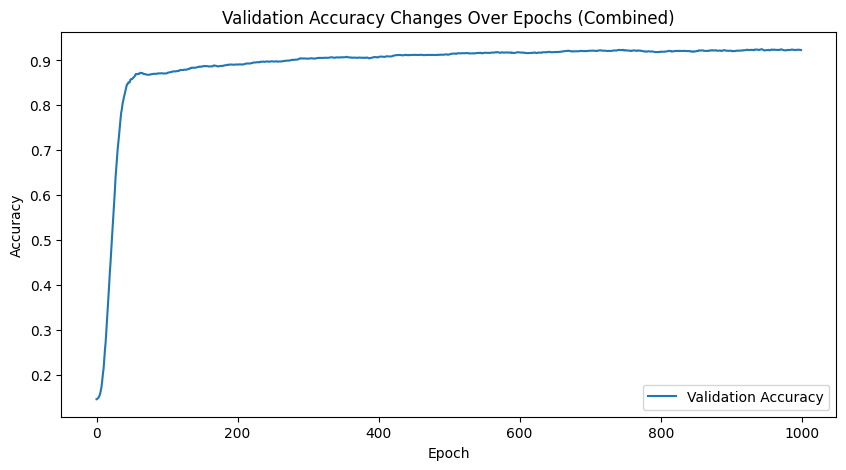

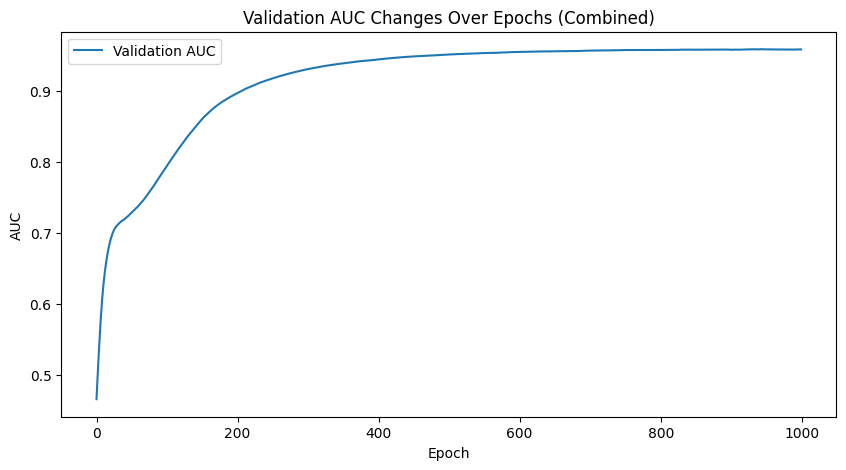

In [46]:
best_val_acc = 0.0
best_state = None

train_losses = []
val_losses = []
val_accuracies = []
val_aucs = []

EPOCHS = 1000
for epoch in tqdm(range(EPOCHS), desc="Training on multiple graphs"):
    # 1) Train step (all training graphs)
    train_loss = train_classifier(pre_model, optimizer, train_val_datalist)
    train_losses.append(train_loss)

    # 2) Validation step (all training graphs)
    val_loss, val_acc, val_auc = evaluate_classifier(pre_model, train_val_datalist, split="val_idx")
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_aucs.append(val_auc)

    # Track best model by validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = pre_model.state_dict()

# Reload best model
if best_state is not None:
    pre_model.load_state_dict(best_state)

print(f"Best validation accuracy: {best_val_acc:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Changes Over Epochs (Combined Training Set)')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy Changes Over Epochs (Combined)')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(val_aucs, label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.title('Validation AUC Changes Over Epochs (Combined)')
plt.show()



In [47]:
@torch.no_grad()
def test_on_withheld_graph(model, data):
    model.eval()
    data = data.to(device)
    
    logits = model(data.x, data.edge_index).squeeze()
    labels = data.y.view(-1)
    
    loss = criterion(logits, labels).item()
    probs = torch.sigmoid(logits)
    binary_pred = (probs > 0.5).float()
    
    correct = (binary_pred == labels).sum().item()
    acc = correct / labels.size(0)
    
    try:
        auc = roc_auc_score(labels.cpu(), probs.cpu())
    except ValueError:
        auc = float('nan')
    
    return loss, acc, auc

test_loss, test_acc, test_auc = test_on_withheld_graph(pre_model, test_data)
print(f"\n=== Final Test on '{test_replicate_name}' ===")
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f} | Test AUC: {test_auc:.4f}")



=== Final Test on '13months-disease-replicate_2' ===
Test Loss: 0.3658 | Test Accuracy: 0.9061 | Test AUC: 0.8436


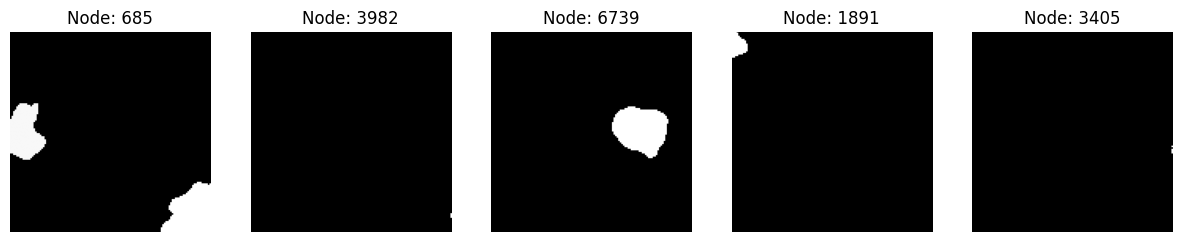

In [48]:
# Get predictions from the classifier
pre_model.eval()
data = graph_data_dict['8months-disease-replicate_1'].clone().to(device)
with torch.no_grad():
    logits = pre_model(data.x, data.edge_index).squeeze()
    preds = (logits.sigmoid() > 0.5).float()

# Identify positive nodes
positive_nodes = (preds == 1).nonzero(as_tuple=True)[0]

# Visualize a subset of the positive nodes' patches images
num_images_to_plot = min(5, len(positive_nodes))  # Plot up to 5 images
fig, axes = plt.subplots(1, num_images_to_plot, figsize=(15, 5))
axes = np.atleast_1d(axes)

# Randomly select positive nodes to plot
random_positive_nodes = random.sample(list(positive_nodes), num_images_to_plot)

for i, node in enumerate(random_positive_nodes):
    patch = data.patches[node].squeeze().to("cpu").numpy()
    axes[i].imshow(patch, cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"Node: {node.item()}")
plt.show()


In [506]:
graph_data_dict

{'8months-disease-replicate_1': Data(x=[8186, 2766], edge_index=[2, 131356], y=[8186, 1], patches=[8186, 128, 128, 1]),
 '13months-disease-replicate_1': Data(x=[10372, 2766], edge_index=[2, 167278], y=[10372, 1], patches=[10372, 128, 128, 1]),
 '8months-disease-replicate_2': Data(x=[8202, 2766], edge_index=[2, 132328], y=[8202, 1], patches=[8202, 128, 128, 1]),
 '13months-disease-replicate_2': Data(x=[9634, 2766], edge_index=[2, 155576], y=[9634, 1], patches=[9634, 128, 128, 1])}

In [51]:
# Store the positive nodes in a dictionary
positive_nodes_dict = {}

for key, data in graph_data_dict.items():
    data = data.clone().to(device)
    with torch.no_grad():
        logits = pre_model(data.x, data.edge_index).squeeze()
        preds = (logits.sigmoid() > 0.5).float()
    positive_nodes = (preds == 1).nonzero(as_tuple=True)[0]
    positive_nodes_dict[key] = positive_nodes

#  Print the number of positive nodes for each replicate
for key, nodes in positive_nodes_dict.items():
    print(f"Number of positive nodes in '{key}': {len(nodes)}")

Number of positive nodes in '8months-disease-replicate_1': 829
Number of positive nodes in '13months-disease-replicate_1': 2303
Number of positive nodes in '8months-disease-replicate_2': 992
Number of positive nodes in '13months-disease-replicate_2': 765


In [510]:
torch_geometric.__version__

'2.6.1'

# Diffusion model

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

from torch_geometric.nn import GATConv
from torch_geometric.data import Data as GData
from torch_geometric.loader import DataLoader as GDataLoader

from diffusers import UNet2DConditionModel, DDPMScheduler
from diffusers.optimization import get_scheduler

from accelerate import Accelerator
from einops import rearrange
from tqdm import tqdm

############################################################################
# 1. CONFIG CLASS
############################################################################

class Config:
    def __init__(self):
        # ------------------
        # Data Related
        # ------------------
        # In your environment, you likely already have graph_data_dict loaded,
        # e.g., from memory. We'll just assume it's accessible outside the class.
        self.batch_size = 2
        self.num_workers = 0  # For DataLoader

        # ------------------
        # GNN Hyperparams
        # ------------------
        self.gnn_in_dim = 2766
        self.gnn_hidden_dim = 128
        self.gnn_out_dim = 256
        self.gnn_num_heads = 4

        # ------------------
        # Diffusion Model Hyperparams
        # ------------------
        # UNet
        self.image_size = 128
        self.in_channels = 1   # 1 channel (binary plaque)
        self.cross_attention_dim = 256
        self.unet_channels = 128
        self.sample_size = 128  # must match image size

        # Scheduler (DDPM)
        self.num_train_timesteps = 1000
        self.beta_start = 1e-4
        self.beta_end = 0.02
        self.beta_schedule = "linear"

        # ------------------
        # Training Hyperparams
        # ------------------
        self.num_epochs = 3
        self.learning_rate = 1e-4
        self.lr_warmup_steps = 100
        self.lr_total_steps = 1000  # for linear scheduler
        self.gradient_accumulation_steps = 1

        # Logging
        self.log_interval = 10


############################################################################
# 2. DATA & DATALOADERS
############################################################################

class GeneGraphDataset(torch.utils.data.Dataset):
    """
    A dataset that holds multiple slices (or replicates), each as a single
    torch_geometric Data object with x, edge_index, patches, etc.
    """
    def __init__(self, graph_data_list):
        """
        graph_data_list: a list of torch_geometric.data.Data objects.
          Each item is something like:
            Data(x=[N, 2766], edge_index=[2, E], patches=[N, 128, 128, 1])
        """
        super().__init__()
        self.graph_data_list = graph_data_list

    def __len__(self):
        return len(self.graph_data_list)

    def __getitem__(self, idx):
        return self.graph_data_list[idx]


def custom_collate_fn(batch):
    """
    By default, DataLoader tries to batch items. However, each item here
    is a single "Data" that might have a variable number of nodes.
    We'll return them as a list for maximum flexibility.
    """
    return batch


def create_dataloaders(config, graph_data_dict):
    """
    Convert the dictionary of graph data:
      {
        '8months-disease-replicate_1': Data(...),
        '13months-disease-replicate_1': Data(...),
        ...
      }
    into a single dataset & dataloader for demonstration.
    You might prefer separate train/val splits, etc.
    """
    # Just gather all Data objects in a list
    data_list = list(graph_data_dict.values())

    dataset = GeneGraphDataset(data_list)
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=config.num_workers,
        collate_fn=custom_collate_fn
    )
    return dataloader


############################################################################
# 3. MODELS: GNN + Conditional UNet
############################################################################

class GATEncoder(nn.Module):
    """
    Simple GAT-based encoder producing per-node embeddings of size gnn_out_dim.
    """
    def __init__(self, in_dim, hidden_dim, out_dim, num_heads=4):
        super().__init__()
        self.gat1 = GATConv(in_dim, hidden_dim, heads=num_heads, concat=True)
        self.gat2 = GATConv(hidden_dim * num_heads, out_dim, heads=1, concat=False)
        self.act = nn.ReLU()

    def forward(self, x, edge_index):
        x = self.gat1(x, edge_index)
        x = self.act(x)
        x = self.gat2(x, edge_index)
        return x


class ConditionalUNet(nn.Module):
    """
    A wrapper around diffusers' UNet2DConditionModel, with cross-attention
    driven by GNN embeddings.
    """
    def __init__(
        self,
        image_size,
        in_channels,
        gnn_out_dim,
        cross_attention_dim,
        unet_channels,
        sample_size
    ):
        super().__init__()

        self.condition_project = nn.Sequential(
            nn.Linear(gnn_out_dim, cross_attention_dim),
            nn.Tanh()
        )

        self.unet = UNet2DConditionModel(
            sample_size=sample_size,
            in_channels=in_channels,
            out_channels=in_channels,
            down_block_types=(
                "CrossAttnDownBlock2D",
                "CrossAttnDownBlock2D",
                "CrossAttnDownBlock2D",
                "DownBlock2D",
            ),
            up_block_types=(
                "UpBlock2D",
                "CrossAttnUpBlock2D",
                "CrossAttnUpBlock2D",
                "CrossAttnUpBlock2D",
            ),
            block_out_channels=(
                unet_channels,
                unet_channels * 2,
                unet_channels * 4,
                unet_channels * 8,  # e.g., 1024 if unet_channels=128
            ),
            cross_attention_dim=cross_attention_dim,
            attention_head_dim=4,
            layers_per_block=2,
        )

    def forward(self, noisy_images, timesteps, node_embeddings):
        """
        noisy_images: (B, C, H, W)
        timesteps: (B,) or scalar
        node_embeddings: (B, N, gnn_out_dim)
        """
        # If we have multiple nodes, we can do a mean or some pooling:
        cond_emb = node_embeddings.mean(dim=1)  # (B, gnn_out_dim)
        context_emb = self.condition_project(cond_emb)  # (B, cross_attention_dim)
        context_emb = context_emb.unsqueeze(1)  # (B, 1, cross_attention_dim)

        output = self.unet(
            sample=noisy_images,
            timestep=timesteps,
            encoder_hidden_states=context_emb
        )
        return output.sample  # (B, C, H, W)


############################################################################
# 4. DIFFUSION UTILS
############################################################################

def compute_diffusion_loss(model, scheduler, real_images, node_embeddings):
    """
    real_images: (B, 1, H, W)
    node_embeddings: (B, N, gnn_out_dim)

    Standard DDPM forward:
      1) sample t
      2) add noise
      3) predict noise
      4) MSE
    """
    device = real_images.device
    bsz = real_images.shape[0]

    # 1) random timesteps
    timesteps = torch.randint(0, scheduler.num_train_timesteps, (bsz,), device=device).long()

    # 2) add noise
    noise = torch.randn_like(real_images)
    noisy_images = scheduler.add_noise(real_images, noise, timesteps)

    # 3) model forward -> predicted noise
    predicted_noise = model(noisy_images, timesteps, node_embeddings)

    # 4) MSE
    loss = F.mse_loss(predicted_noise, noise)
    return loss


############################################################################
# 5. TRAINING & VALIDATION / FORWARD PASS CHECK
############################################################################

def forward_pass_check(gnn, unet, scheduler, batch, device="cpu"):
    """
    Quickly validate shape consistency and basic forward pass on a small batch.
    """
    # 'batch' is a list of Graph Data objects, each with x, edge_index, patches, etc.
    # We'll create a mini-batch of size B from these items. 
    # For demonstration, let's pick one patch per graph (first node).
    # Or you can store them in a more complex manner if needed.

    gnn.eval()
    unet.eval()

    real_images_list = []
    node_emb_list = []

    for gdata in batch:
        gdata = gdata.to(device)

        # GNN
        emb = gnn(gdata.x, gdata.edge_index)  # (num_nodes, gnn_out_dim)

        # We select the first node's patch: shape = (128,128,1)
        # Convert to (1,128,128) to keep the channels in front or the end
        # We'll keep the channel as [1, 128, 128]
        # If the dataset’s patches are (N,128,128,1), do a squeeze
        patch = gdata.patches[0]  # => shape [128,128,1]
        patch = patch.permute(2,0,1)  # => (1,128,128) i.e. (C,H,W)

        real_images_list.append(patch.unsqueeze(0))     # => (1,1,128,128)
        node_emb_list.append(emb.unsqueeze(0))          # => (1,N,gnn_out_dim)

    real_images_batch = torch.cat(real_images_list, dim=0).to(device)  # (B,1,128,128)
    node_emb_batch = torch.cat(node_emb_list, dim=0).to(device)        # (B,N,gnn_out_dim)

    with torch.no_grad():
        # compute the diffusion loss
        loss = compute_diffusion_loss(unet, scheduler, real_images_batch, node_emb_batch)

    print(f"[Forward Pass Check] real_images_batch shape: {real_images_batch.shape}")
    print(f"[Forward Pass Check] node_emb_batch shape: {node_emb_batch.shape}")
    print(f"[Forward Pass Check] Loss: {loss.item():.6f}")

    # If we reach here, shapes are valid and forward pass is working fine.


def train_diffusion(config, graph_data_dict):
    """
    Main function to:
      1) Create Dataloader
      2) Build Models + Optim
      3) Validate Forward Pass
      4) Train with Accelerator
    """
    accelerator = Accelerator()
    device = accelerator.device

    # --------------------------
    #  A) Data
    # --------------------------
    dataloader = create_dataloaders(config, graph_data_dict)

    # --------------------------
    #  B) Initialize Models
    # --------------------------
    gnn_encoder = GATEncoder(
        in_dim=config.gnn_in_dim,
        hidden_dim=config.gnn_hidden_dim,
        out_dim=config.gnn_out_dim,
        num_heads=config.gnn_num_heads
    )

    conditional_unet = ConditionalUNet(
        image_size=config.image_size,
        in_channels=config.in_channels,
        gnn_out_dim=config.gnn_out_dim,
        cross_attention_dim=config.cross_attention_dim,
        unet_channels=config.unet_channels,
        sample_size=config.sample_size
    )

    # Diffusion Scheduler
    scheduler = DDPMScheduler(
        num_train_timesteps=config.num_train_timesteps,
        beta_start=config.beta_start,
        beta_end=config.beta_end,
        beta_schedule=config.beta_schedule,
    )

    # Optimizer
    optimizer = torch.optim.Adam(
        list(gnn_encoder.parameters()) + list(conditional_unet.parameters()),
        lr=config.learning_rate
    )

    # LR Scheduler
    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=config.lr_warmup_steps,
        num_training_steps=config.lr_total_steps
    )

    # --------------------------
    #  C) Prepare with Accelerator
    # --------------------------
    gnn_encoder, conditional_unet, optimizer, dataloader = accelerator.prepare(
        gnn_encoder,
        conditional_unet,
        optimizer,
        dataloader
    )

    # After prepare, the models, optimizer, and data are on the correct device
    # (CPU, single GPU, or multi-GPU).
    # We can do a quick forward pass check on a small batch from dataloader:
    sample_batch = next(iter(dataloader))
    forward_pass_check(gnn_encoder, conditional_unet, scheduler, sample_batch, device)

    # --------------------------
    #  D) Training Loop
    # --------------------------
    gnn_encoder.train()
    conditional_unet.train()

    global_step = 0
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch}", leave=True)
        for i, batch in enumerate(progress_bar):
            # batch is a list of Data objects
            # We'll do the same approach: pick first node's patch or your own strategy

            real_images_list = []
            node_emb_list = []

            for gdata in batch:
                # GNN forward
                x = gdata.x
                edge_index = gdata.edge_index
                emb = gnn_encoder(x, edge_index)

                # pick first node's patch
                patch = gdata.patches[0]  # shape => (128,128,1)
                patch = patch.permute(2,0,1)  # => (1,128,128)
                real_images_list.append(patch.unsqueeze(0))  # => (1,1,128,128)
                node_emb_list.append(emb.unsqueeze(0))       # => (1,N,out_dim)

            real_images_batch = torch.cat(real_images_list, dim=0)
            node_emb_batch = torch.cat(node_emb_list, dim=0)

            # Move to correct device if needed
            real_images_batch, node_emb_batch = real_images_batch.to(device), node_emb_batch.to(device)

            loss = compute_diffusion_loss(conditional_unet, scheduler, real_images_batch, node_emb_batch)
            accelerator.backward(loss)

            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

            global_step += 1

            # Logging
            if global_step % config.log_interval == 0:
                progress_bar.set_postfix({
                    "step": global_step,
                    "loss": loss.item()
                })

    print("Training complete.")
    return gnn_encoder, conditional_unet, scheduler


In [39]:
# Suppose we have your "graph_data_dict" loaded:
# {
#  '8months-disease-replicate_1': Data(x=[8186, 2766], edge_index=[2, 131356], patches=[8186,128,128,1]),
#   ...
# }

# 1) Create a config
config = Config()
config.num_epochs = 5
config.batch_size = 2
config.learning_rate = 3e-4
config.log_interval = 5
# etc. Adjust as needed

# 2) Train
gnn_encoder, conditional_unet, scheduler = train_diffusion(config, graph_data_dict)

# 3) After training,
#    you can use `gnn_encoder` + `conditional_unet` to sample patches or
#    compute new reconstructions.


Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 9634 but got size 10372 for tensor number 1 in the list.

In [27]:
graph_data_dict

{'8months-disease-replicate_1': Data(x=[8186, 2766], edge_index=[2, 131356], y=[8186, 1], patches=[8186, 128, 128, 1]),
 '13months-disease-replicate_1': Data(x=[10372, 2766], edge_index=[2, 167278], y=[10372, 1], patches=[10372, 128, 128, 1]),
 '8months-disease-replicate_2': Data(x=[8202, 2766], edge_index=[2, 132328], y=[8202, 1], patches=[8202, 128, 128, 1]),
 '13months-disease-replicate_2': Data(x=[9634, 2766], edge_index=[2, 155576], y=[9634, 1], patches=[9634, 128, 128, 1])}

# VGAE Trial

In [73]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch_geometric.nn import GATConv
from torch_geometric.data import Data as GData
from torch_geometric.loader import DataLoader as GDataLoader

import numpy as np

from tqdm.auto import tqdm  # safer for notebooks/scripts

from diffusers import UNet2DConditionModel, DDPMScheduler
from accelerate import Accelerator


In [74]:
class Config:
    def __init__(self):
        # Graph VAE
        self.gnn_in_dim = 2766            # gene expression dimension
        self.gnn_hidden_dim = 128
        self.gnn_out_dim = 128            # final embedding size for GNN layers
        self.num_gat_heads = 4           # number of attention heads for GAT
        self.vae_latent_dim = 64         # dimension of latent z
        self.gnn_num_epochs = 300
        self.gnn_lr = 1e-3
        self.kl_weight = 0.01
        self.recon_weight = 1.0          # adjacency recon weight

        # Diffusion
        self.diffusion_lr = 1e-4
        self.diffusion_epochs = 60
        self.num_train_timesteps = 1000
        self.beta_start = 1e-4
        self.beta_end = 0.02
        self.beta_schedule = "linear"

        # For the U-Net size
        self.cross_attention_dim = 128
        self.unet_channels = 64          # base channels
        self.image_size = 128
        self.in_channels = 1            # single-channel (binary) patches

        # Data
        self.batch_size = 2             # for GNN training
        self.num_workers = 0

        # Node-level dataset for diffusion
        self.diff_batch_size = 64       # how many (z, patch) we feed into the diffusion model
        self.sample_latent = True       # whether to sample z = mu + sigma*eps or use mu only


In [75]:
class GeneGraphDataset(torch.utils.data.Dataset):
    def __init__(self, data_list):
        super().__init__()
        self.data_list = data_list

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        return self.data_list[idx]


def custom_collate_fn(batch):
    return batch


def create_graph_dataloader(config, graph_data_dict):
    data_list = list(graph_data_dict.values())
    dataset = GeneGraphDataset(data_list)
    loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=config.num_workers,
        collate_fn=custom_collate_fn
    )
    return loader


In [76]:
class ResidualGATBlock(nn.Module):
    """
    One block of GATConv with skip connection.
    """
    def __init__(self, in_dim, out_dim, heads=4):
        super().__init__()
        self.gat = GATConv(in_dim, out_dim, heads=heads, concat=True)
        self.lin = nn.Linear(in_dim, out_dim*heads)  # for residual match
        self.act = nn.ELU()  # or GELU, etc.

    def forward(self, x, edge_index):
        h = self.gat(x, edge_index)             # (N, out_dim * heads)
        # Residual
        res = self.lin(x)
        out = self.act(h + res)                 # (N, out_dim * heads)
        return out


class GATVAEEncoder(nn.Module):
    """
    Multi-block GAT encoder to produce mu, logvar for each node.
    We'll do 2 residual blocks, then separate heads for mu/logvar.
    """
    def __init__(self, in_dim, hidden_dim, out_dim, latent_dim, num_heads=4):
        super().__init__()
        # block1 transforms in_dim -> hidden_dim
        self.block1 = ResidualGATBlock(in_dim, hidden_dim, heads=num_heads)
        # block2 transforms hidden_dim*num_heads -> out_dim
        self.block2 = ResidualGATBlock(hidden_dim*num_heads, out_dim, heads=num_heads)

        # final MLP for mu/logvar
        # after block2, dimension = out_dim*num_heads
        final_dim = out_dim*num_heads
        self.mu_proj = nn.Linear(final_dim, latent_dim)
        self.logvar_proj = nn.Linear(final_dim, latent_dim)

    def forward(self, x, edge_index):
        h = self.block1(x, edge_index)   # (N, hidden_dim*heads)
        h = self.block2(h, edge_index)   # (N, out_dim*heads)
        mu = self.mu_proj(h)
        logvar = self.logvar_proj(h)
        return mu, logvar

class GATVAEDecoder(nn.Module):
    def forward(self, z):
        # z: (N, latent_dim)
        return torch.sigmoid(z @ z.t())

class GATVAE(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, latent_dim, num_heads=4):
        super().__init__()
        self.encoder = GATVAEEncoder(in_dim, hidden_dim, out_dim, latent_dim, num_heads)
        self.decoder = GATVAEDecoder()

    def reparam(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x, edge_index):
        mu, logvar = self.encoder(x, edge_index)
        z = self.reparam(mu, logvar)
        A_hat = self.decoder(z)  # (N,N)
        return A_hat, mu, logvar, z
    

def gat_vae_loss(A_hat, A_real, mu, logvar, kl_weight=0.01, recon_weight=1.0):
    """
    A_hat: (N,N), adjacency prediction
    A_real: (N,N), adjacency ground truth
    mu, logvar: (N,latent_dim)
    """
    recon_loss = F.binary_cross_entropy(A_hat, A_real)
    kl = -0.5 * torch.mean(torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=-1))
    loss = recon_weight * recon_loss + kl_weight * kl
    return loss, recon_loss, kl



In [77]:
from tqdm import tqdm

def train_gat_vae(config, graph_data_dict):
    """
    Train the GAT-based VAE on adjacency reconstruction.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Build model
    vae_model = GATVAE(
        in_dim=config.gnn_in_dim,
        hidden_dim=config.gnn_hidden_dim,
        out_dim=config.gnn_out_dim,
        latent_dim=config.vae_latent_dim,
        num_heads=config.num_gat_heads
    ).to(device)

    optimizer = optim.Adam(vae_model.parameters(), lr=config.gnn_lr)
    dataloader = create_graph_dataloader(config, graph_data_dict)

    vae_model.train()
    pbar = tqdm(range(config.gnn_num_epochs), desc='Training GAT-VAE')
    
    for epoch in pbar:
        total_loss, total_recon, total_kl = 0, 0, 0
        count = 0

        for batch in dataloader:
            for gdata in batch:
                gdata = gdata.to(device)
                x, edge_index = gdata.x, gdata.edge_index
                N = x.size(0)

                A_real = torch.zeros((N, N), device=device)
                A_real[edge_index[0], edge_index[1]] = 1.0
                A_real[edge_index[1], edge_index[0]] = 1.0

                optimizer.zero_grad()
                A_hat, mu, logvar, z = vae_model(x, edge_index)

                loss, recon, kl = gat_vae_loss(
                    A_hat, A_real, mu, logvar,
                    kl_weight=config.kl_weight,
                    recon_weight=config.recon_weight
                )
                loss.backward()
                optimizer.step()

                total_loss += float(loss.item())
                total_recon += float(recon.item())
                total_kl += float(kl.item())
                count += 1

        avg_loss = total_loss / (count+1e-9)
        avg_recon = total_recon / (count+1e-9)
        avg_kl = total_kl / (count+1e-9)
        
        # Update progress bar with current losses
        pbar.set_postfix({
            'loss': f'{avg_loss:.4f}',
            'recon': f'{avg_recon:.4f}',
            'kl': f'{avg_kl:.4f}'
        })

    return vae_model

In [78]:
import torch
from torch.utils.data import Dataset, DataLoader

class NodeLatentDataset(Dataset):
    """
    Holds (z, patch) for each positive node across all graphs.
    """
    def __init__(self, pairs):
        """
        Args:
            pairs (list of tuples): Each tuple contains (z, patch) for a positive node.
        """
        self.z_list = [z for z, patch in pairs]
        self.patch_list = [patch for z, patch in pairs]

    def __len__(self):
        return len(self.z_list)

    def __getitem__(self, idx):
        return self.z_list[idx], self.patch_list[idx]


def build_node_level_pairs(vae_model, graph_data_dict, positive_nodes_dict, device, sample=True):
    """
    Builds a list of (z, patch) pairs for positive nodes only.

    Args:
        vae_model (torch.nn.Module): Trained VAE model (encoder part used here).
        graph_data_dict (dict): Dictionary of graph data objects {key: GData(...)}.
        positive_nodes_dict (dict): Dictionary containing positive node indices {key: tensor}.
        device (torch.device): Device to perform computations on.
        sample (bool): If True, sample z using mu and std; else use mu directly.

    Returns:
        list of tuples: Each tuple contains (z, patch) for a positive node.
    """
    vae_model.encoder.eval().to(device)
    pairs = []

    with torch.no_grad():
        for key, gdata in graph_data_dict.items():
            gdata = gdata.to(device)
            x, edge_index, patches = gdata.x, gdata.edge_index, gdata.patches

            # Encode the nodes to get mu and logvar
            mu, logvar = vae_model.encoder(x, edge_index)  # Shape: (N, latent_dim)

            if sample:
                std = torch.exp(0.5 * logvar)
                eps = torch.randn_like(std)
                z_nodes = mu + eps * std
            else:
                z_nodes = mu

            # Retrieve positive node indices for the current graph
            positive_indices = positive_nodes_dict.get(key, torch.tensor([], dtype=torch.long, device=device))

            # Iterate over positive node indices
            for idx in positive_indices:
                patch = patches[idx]

                # Reshape patch if necessary
                if patch.dim() == 4:
                    patch = patch.squeeze(0)  # From (1, H, W, C) to (H, W, C)
                if patch.shape[-1] == 1:
                    patch = patch.permute(2, 0, 1)  # From (H, W, 1) to (1, H, W)

                # Append the (z, patch) pair as CPU tensors
                pairs.append((z_nodes[idx].cpu(), patch.cpu()))

    return pairs


def create_node_level_dataloader(pairs, batch_size=64, shuffle=True, num_workers=0):
    """
    Creates a DataLoader for the node-level dataset.

    Args:
        pairs (list of tuples): Each tuple contains (z, patch) for a positive node.
        batch_size (int): Number of samples per batch.
        shuffle (bool): Whether to shuffle the data.
        num_workers (int): Number of subprocesses for data loading.

    Returns:
        DataLoader: DataLoader for the positive node dataset.
    """
    dataset = NodeLatentDataset(pairs)
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers
    )
    return loader

In [79]:
class ConditionalUNet(nn.Module):
    """
    A smaller UNet2DConditionModel with cross-attention on z.
    """
    def __init__(self, z_dim, cross_attention_dim=128, base_channels=64, sample_size=128):
        super().__init__()
        self.z_to_context = nn.Sequential(
            nn.Linear(z_dim, cross_attention_dim),
            nn.Tanh()
        )

        # We'll do a 2-block U-Net to reduce memory usage
        self.unet = UNet2DConditionModel(
            sample_size=sample_size,
            in_channels=1,
            out_channels=1,
            down_block_types=(
                "DownBlock2D",
                "DownBlock2D",
                "CrossAttnDownBlock2D",
            ),
            up_block_types=(
                "CrossAttnUpBlock2D",
                "UpBlock2D",
                "UpBlock2D",
            ),
            block_out_channels=(base_channels, base_channels*2, base_channels*4),
            cross_attention_dim=cross_attention_dim,
            attention_head_dim=1,
            layers_per_block=1,
        )

    def forward(self, noisy_imgs, timesteps, z):
        """
        noisy_imgs: (B,1,128,128)
        z: (B,z_dim)
        """
        context = self.z_to_context(z)    # (B,cross_attention_dim)
        context = context.unsqueeze(1)    # (B,1,cross_attention_dim)

        outputs = self.unet(
            sample=noisy_imgs,
            timestep=timesteps,
            encoder_hidden_states=context
        )
        return outputs.sample


def diffusion_loss(model, scheduler, real_images, z, device):
    bsz = real_images.shape[0]
    timesteps = torch.randint(0, scheduler.num_train_timesteps, (bsz,), device=device).long()
    noise = torch.randn_like(real_images)
    noisy_images = scheduler.add_noise(real_images, noise, timesteps)
    pred_noise = model(noisy_images, timesteps, z)
    return F.mse_loss(pred_noise, noise)


In [80]:
def train_diffusion_on_node_latents(
    config,
    node_dataloader,
    z_dim
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    accelerator = Accelerator(mixed_precision="fp16")  # optional for memory saving

    # Build a small conditional U-Net
    cond_unet = ConditionalUNet(
        z_dim=z_dim,
        cross_attention_dim=config.cross_attention_dim,
        base_channels=config.unet_channels,
        sample_size=config.image_size
    ).to(device)

    # Diffusion scheduler
    scheduler = DDPMScheduler(
        num_train_timesteps=config.num_train_timesteps,
        beta_start=config.beta_start,
        beta_end=config.beta_end,
        beta_schedule=config.beta_schedule
    )

    optimizer = optim.Adam(cond_unet.parameters(), lr=config.diffusion_lr)

    # Prepare with Accelerator
    cond_unet, optimizer, node_dataloader = accelerator.prepare(cond_unet, optimizer, node_dataloader)

    cond_unet.train()
    global_step = 0
    for epoch in range(config.diffusion_epochs):
        total_loss, count = 0, 0
        progress_bar = tqdm(node_dataloader, desc=f"DiffEpoch {epoch}", leave=True)
        for z_batch, patch_batch in progress_bar:
            z_batch = z_batch.to(device)
            patch_batch = patch_batch.to(device).float()

            loss = diffusion_loss(cond_unet, scheduler, patch_batch, z_batch, device=device)
            accelerator.backward(loss)
            optimizer.step()
            optimizer.zero_grad()

            total_loss += loss.item()
            count += 1
            global_step += 1

            if global_step % 50 == 0:
                progress_bar.set_postfix({
                    "step": global_step,
                    "loss": loss.item()
                })

        avg_loss = total_loss / (count+1e-9)
        print(f"Epoch {epoch}: avg_loss={avg_loss:.4f}")

    return cond_unet, scheduler


In [81]:
config = Config()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2) Train GAT-VAE
vae_model = train_gat_vae(config, graph_data_dict)



Training GAT-VAE: 100%|██████████| 300/300 [00:21<00:00, 13.65it/s, loss=1.1940, recon=0.8514, kl=34.2597]


In [82]:
# 3) Build node-level (z, patch) dataset
#    Freeze VAE encoder, compute mu, logvar => z
node_pairs = build_node_level_pairs(
    vae_model=vae_model,
    graph_data_dict=graph_data_dict,
    positive_nodes_dict=positive_nodes_dict,
    device=device,
    sample=config.sample_latent  # True => sample z
)
print(f"[INFO] Created node-level dataset with {len(node_pairs)} items.")

# 4) Create DataLoader for diffusion
node_dataloader = create_node_level_dataloader(
    node_pairs,
    batch_size=config.diff_batch_size,
    shuffle=True
)

[INFO] Created node-level dataset with 4889 items.


In [83]:
# 5) Train diffusion on (z, patch)
#    z_dim = config.vae_latent_dim
cond_unet, scheduler = train_diffusion_on_node_latents(
    config,
    node_dataloader,
    z_dim=config.vae_latent_dim
)


Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
DiffEpoch 0:   0%|          | 0/77 [00:00<?, ?it/s]/public/home/jijh/micromamba/envs/gpu_env/lib/python3.12/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
DiffEpoch 0: 100%|██████████| 77/77 [00:13<00:00,  5.68it/s, step=50, loss=0.395]


Epoch 0: avg_loss=0.5222


DiffEpoch 1: 100%|██████████| 77/77 [00:13<00:00,  5.67it/s, step=150, loss=0.241]


Epoch 1: avg_loss=0.3099


DiffEpoch 2: 100%|██████████| 77/77 [00:15<00:00,  5.12it/s, step=200, loss=0.124]


Epoch 2: avg_loss=0.1845


DiffEpoch 3: 100%|██████████| 77/77 [00:27<00:00,  2.76it/s, step=300, loss=0.0958]


Epoch 3: avg_loss=0.1037


DiffEpoch 4: 100%|██████████| 77/77 [00:27<00:00,  2.78it/s, step=350, loss=0.0789]


Epoch 4: avg_loss=0.0753


DiffEpoch 5: 100%|██████████| 77/77 [00:27<00:00,  2.78it/s, step=450, loss=0.106] 


Epoch 5: avg_loss=0.0599


DiffEpoch 6: 100%|██████████| 77/77 [00:27<00:00,  2.78it/s, step=500, loss=0.0293]


Epoch 6: avg_loss=0.0498


DiffEpoch 7: 100%|██████████| 77/77 [00:28<00:00,  2.72it/s, step=600, loss=0.0516]


Epoch 7: avg_loss=0.0420


DiffEpoch 8: 100%|██████████| 77/77 [00:27<00:00,  2.76it/s, step=650, loss=0.0205]


Epoch 8: avg_loss=0.0361


DiffEpoch 9: 100%|██████████| 77/77 [00:26<00:00,  2.92it/s, step=750, loss=0.0184]


Epoch 9: avg_loss=0.0358


DiffEpoch 10: 100%|██████████| 77/77 [00:28<00:00,  2.72it/s, step=800, loss=0.025]


Epoch 10: avg_loss=0.0344


DiffEpoch 11: 100%|██████████| 77/77 [00:27<00:00,  2.76it/s, step=900, loss=0.0318]


Epoch 11: avg_loss=0.0289


DiffEpoch 12: 100%|██████████| 77/77 [00:27<00:00,  2.77it/s, step=1000, loss=0.0307]


Epoch 12: avg_loss=0.0288


DiffEpoch 13: 100%|██████████| 77/77 [00:27<00:00,  2.77it/s, step=1050, loss=0.0278]


Epoch 13: avg_loss=0.0257


DiffEpoch 14: 100%|██████████| 77/77 [00:28<00:00,  2.71it/s, step=1150, loss=0.0259]


Epoch 14: avg_loss=0.0289


DiffEpoch 15: 100%|██████████| 77/77 [00:27<00:00,  2.78it/s, step=1200, loss=0.0254]


Epoch 15: avg_loss=0.0264


DiffEpoch 16: 100%|██████████| 77/77 [00:27<00:00,  2.75it/s, step=1300, loss=0.0355]


Epoch 16: avg_loss=0.0254


DiffEpoch 17: 100%|██████████| 77/77 [00:27<00:00,  2.77it/s, step=1350, loss=0.0266]


Epoch 17: avg_loss=0.0249


DiffEpoch 18: 100%|██████████| 77/77 [00:28<00:00,  2.72it/s, step=1450, loss=0.0116]


Epoch 18: avg_loss=0.0238


DiffEpoch 19: 100%|██████████| 77/77 [00:27<00:00,  2.75it/s, step=1500, loss=0.0141]


Epoch 19: avg_loss=0.0206


DiffEpoch 20: 100%|██████████| 77/77 [00:26<00:00,  2.87it/s, step=1600, loss=0.01]  


Epoch 20: avg_loss=0.0203


DiffEpoch 21: 100%|██████████| 77/77 [00:28<00:00,  2.72it/s, step=1650, loss=0.0233]


Epoch 21: avg_loss=0.0213


DiffEpoch 22: 100%|██████████| 77/77 [00:27<00:00,  2.76it/s, step=1750, loss=0.0209]


Epoch 22: avg_loss=0.0201


DiffEpoch 23: 100%|██████████| 77/77 [00:27<00:00,  2.77it/s, step=1800, loss=0.0273]


Epoch 23: avg_loss=0.0185


DiffEpoch 24: 100%|██████████| 77/77 [00:27<00:00,  2.80it/s, step=1900, loss=0.02]  


Epoch 24: avg_loss=0.0199


DiffEpoch 25: 100%|██████████| 77/77 [00:28<00:00,  2.74it/s, step=2000, loss=0.0149]


Epoch 25: avg_loss=0.0230


DiffEpoch 26: 100%|██████████| 77/77 [00:27<00:00,  2.75it/s, step=2050, loss=0.0225]


Epoch 26: avg_loss=0.0197


DiffEpoch 27: 100%|██████████| 77/77 [00:27<00:00,  2.77it/s, step=2150, loss=0.016]


Epoch 27: avg_loss=0.0178


DiffEpoch 28: 100%|██████████| 77/77 [00:27<00:00,  2.77it/s, step=2200, loss=0.0186]


Epoch 28: avg_loss=0.0168


DiffEpoch 29: 100%|██████████| 77/77 [00:28<00:00,  2.72it/s, step=2300, loss=0.0137]


Epoch 29: avg_loss=0.0170


DiffEpoch 30: 100%|██████████| 77/77 [00:27<00:00,  2.81it/s, step=2350, loss=0.0138]


Epoch 30: avg_loss=0.0158


DiffEpoch 31: 100%|██████████| 77/77 [00:27<00:00,  2.75it/s, step=2450, loss=0.0185]


Epoch 31: avg_loss=0.0178


DiffEpoch 32: 100%|██████████| 77/77 [00:28<00:00,  2.72it/s, step=2500, loss=0.0131]


Epoch 32: avg_loss=0.0154


DiffEpoch 33: 100%|██████████| 77/77 [00:27<00:00,  2.75it/s, step=2600, loss=0.0157]


Epoch 33: avg_loss=0.0158


DiffEpoch 34: 100%|██████████| 77/77 [00:27<00:00,  2.77it/s, step=2650, loss=0.0214]


Epoch 34: avg_loss=0.0179


DiffEpoch 35: 100%|██████████| 77/77 [00:27<00:00,  2.76it/s, step=2750, loss=0.016] 


Epoch 35: avg_loss=0.0139


DiffEpoch 36: 100%|██████████| 77/77 [00:28<00:00,  2.72it/s, step=2800, loss=0.00909]


Epoch 36: avg_loss=0.0132


DiffEpoch 37: 100%|██████████| 77/77 [00:27<00:00,  2.79it/s, step=2900, loss=0.0199]


Epoch 37: avg_loss=0.0139


DiffEpoch 38: 100%|██████████| 77/77 [00:27<00:00,  2.77it/s, step=3000, loss=0.02]  


Epoch 38: avg_loss=0.0146


DiffEpoch 39: 100%|██████████| 77/77 [00:27<00:00,  2.82it/s, step=3050, loss=0.034]


Epoch 39: avg_loss=0.0164


DiffEpoch 40: 100%|██████████| 77/77 [00:28<00:00,  2.72it/s, step=3150, loss=0.0266]


Epoch 40: avg_loss=0.0159


DiffEpoch 41: 100%|██████████| 77/77 [00:28<00:00,  2.75it/s, step=3200, loss=0.0152]


Epoch 41: avg_loss=0.0133


DiffEpoch 42: 100%|██████████| 77/77 [00:27<00:00,  2.76it/s, step=3300, loss=0.0111]


Epoch 42: avg_loss=0.0139


DiffEpoch 43: 100%|██████████| 77/77 [00:28<00:00,  2.74it/s, step=3350, loss=0.0139]


Epoch 43: avg_loss=0.0127


DiffEpoch 44: 100%|██████████| 77/77 [00:28<00:00,  2.73it/s, step=3450, loss=0.0152]


Epoch 44: avg_loss=0.0142


DiffEpoch 45: 100%|██████████| 77/77 [00:27<00:00,  2.80it/s, step=3500, loss=0.0154]


Epoch 45: avg_loss=0.0157


DiffEpoch 46: 100%|██████████| 77/77 [00:27<00:00,  2.76it/s, step=3600, loss=0.0123] 


Epoch 46: avg_loss=0.0122


DiffEpoch 47: 100%|██████████| 77/77 [00:28<00:00,  2.72it/s, step=3650, loss=0.0126]


Epoch 47: avg_loss=0.0138


DiffEpoch 48: 100%|██████████| 77/77 [00:27<00:00,  2.76it/s, step=3750, loss=0.0183] 


Epoch 48: avg_loss=0.0134


DiffEpoch 49: 100%|██████████| 77/77 [00:27<00:00,  2.77it/s, step=3850, loss=0.00853]


Epoch 49: avg_loss=0.0131


DiffEpoch 50: 100%|██████████| 77/77 [00:27<00:00,  2.77it/s, step=3900, loss=0.00934]


Epoch 50: avg_loss=0.0133


DiffEpoch 51: 100%|██████████| 77/77 [00:28<00:00,  2.71it/s, step=4000, loss=0.0101]


Epoch 51: avg_loss=0.0133


DiffEpoch 52: 100%|██████████| 77/77 [00:27<00:00,  2.77it/s, step=4050, loss=0.00916]


Epoch 52: avg_loss=0.0118


DiffEpoch 53: 100%|██████████| 77/77 [00:27<00:00,  2.75it/s, step=4150, loss=0.0156]


Epoch 53: avg_loss=0.0104


DiffEpoch 54: 100%|██████████| 77/77 [00:28<00:00,  2.75it/s, step=4200, loss=0.0111]


Epoch 54: avg_loss=0.0125


DiffEpoch 55: 100%|██████████| 77/77 [00:28<00:00,  2.71it/s, step=4300, loss=0.0107]


Epoch 55: avg_loss=0.0126


DiffEpoch 56: 100%|██████████| 77/77 [00:27<00:00,  2.75it/s, step=4350, loss=0.0107]


Epoch 56: avg_loss=0.0124


DiffEpoch 57: 100%|██████████| 77/77 [00:27<00:00,  2.76it/s, step=4450, loss=0.00837]


Epoch 57: avg_loss=0.0111


DiffEpoch 58: 100%|██████████| 77/77 [00:27<00:00,  2.84it/s, step=4500, loss=0.0206]


Epoch 58: avg_loss=0.0132


DiffEpoch 59: 100%|██████████| 77/77 [00:28<00:00,  2.72it/s, step=4600, loss=0.0122] 

Epoch 59: avg_loss=0.0127



Generating image for Sample 1/5


Generating Image:   0%|          | 0/1000 [00:00<?, ?it/s]

Sample 1 - MSE: 0.4502, SSIM: -0.0006


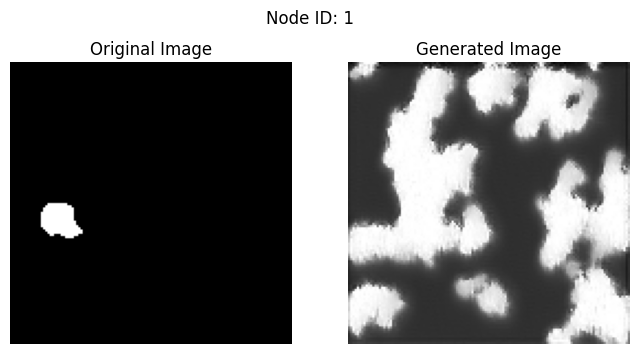


Generating image for Sample 2/5


Generating Image:   0%|          | 0/1000 [00:00<?, ?it/s]

Sample 2 - MSE: 0.3985, SSIM: 0.0364


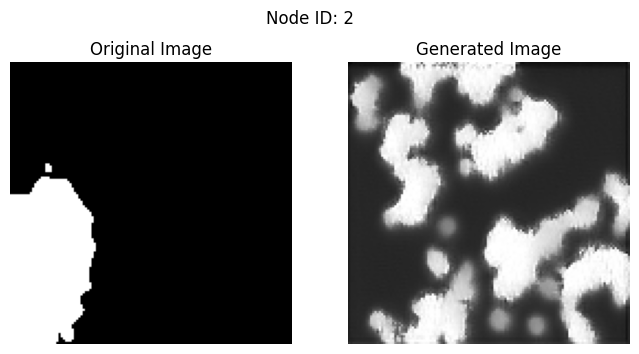


Generating image for Sample 3/5


Generating Image:   0%|          | 0/1000 [00:00<?, ?it/s]

Sample 3 - MSE: 0.5217, SSIM: -0.0012


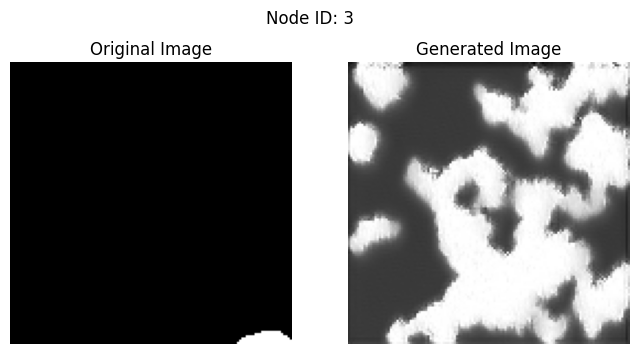


Generating image for Sample 4/5


Generating Image:   0%|          | 0/1000 [00:00<?, ?it/s]

Sample 4 - MSE: 0.4772, SSIM: 0.0060


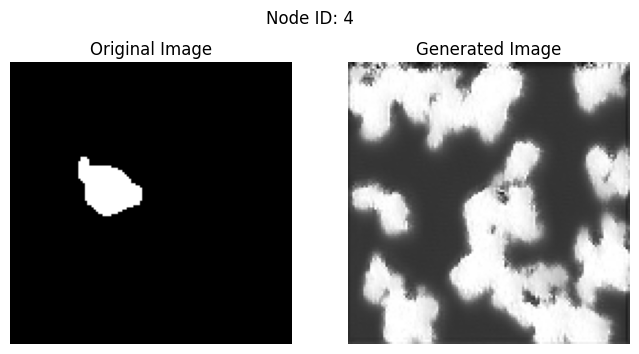


Generating image for Sample 5/5


Generating Image:   0%|          | 0/1000 [00:00<?, ?it/s]

Sample 5 - MSE: 0.4073, SSIM: 0.0238


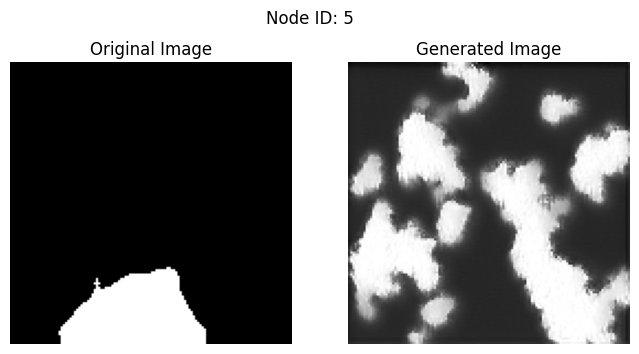


[Summary] Average MSE: 0.4510, Average SSIM: 0.0129


In [85]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch_geometric.nn import GATConv
from torch_geometric.data import Data as GData
from torch_geometric.loader import DataLoader as GDataLoader

import numpy as np

from tqdm.auto import tqdm  # safer for notebooks/scripts

from diffusers import UNet2DConditionModel, DDPMScheduler
from accelerate import Accelerator

import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim_metric

# Ensure scikit-image and matplotlib are installed
# You can install them via pip if not already installed:
# !pip install scikit-image matplotlib

# ... [Your existing code for Config, GeneGraphDataset, ResidualGATBlock, GATVAEEncoder, GATVAEDecoder, GATVAE, gat_vae_loss, train_gat_vae, NodeLatentDataset, build_node_level_pairs, create_node_level_dataloader, ConditionalUNet, diffusion_loss, train_diffusion_on_node_latents] ...

# Assuming all the above classes and functions are defined here as per your initial code.

# -------------------- Image Generation and Comparison -------------------- #

def generate_image(z, cond_unet, scheduler, device, num_inference_steps=1000):
    """
    Generates an image from latent vector z using the trained diffusion model.

    Args:
        z (torch.Tensor): Latent vector of shape (z_dim,).
        cond_unet (ConditionalUNet): Trained conditional UNet model.
        scheduler (DDPMScheduler): Trained diffusion scheduler.
        device (torch.device): Device to perform computation on.
        num_inference_steps (int): Number of denoising steps.

    Returns:
        torch.Tensor: Generated image of shape (1, H, W).
    """
    cond_unet.eval()
    with torch.no_grad():
        # Initialize the scheduler
        scheduler.set_timesteps(num_inference_steps)
        timesteps = scheduler.timesteps

        # Sample initial noise
        latents = torch.randn((1, 1, config.image_size, config.image_size)).to(device)

        for t in tqdm(timesteps, desc="Generating Image"):
            t_batch = torch.tensor([t], dtype=torch.long).to(device)  # Shape: (1,)
            # Repeat z to match batch size
            z_batch = z.unsqueeze(0).to(device)  # Shape: (1, z_dim)

            # Predict the noise residual
            noise_pred = cond_unet(noisy_imgs=latents, timesteps=t_batch, z=z_batch)

            # Compute the previous noisy sample x_t -> x_t-1
            latents = scheduler.step(noise_pred, t, latents).prev_sample

        # Clamp the latents to [0, 1]
        generated_image = torch.clamp(latents, 0, 1).squeeze(0).cpu()
        return generated_image

def compute_metrics(generated_image, original_image):
    """
    Computes MSE and SSIM between generated and original images.

    Args:
        generated_image (torch.Tensor): Generated image tensor of shape (1, H, W).
        original_image (torch.Tensor): Original image tensor of shape (1, H, W).

    Returns:
        dict: Dictionary containing 'mse' and 'ssim'.
    """
    gen_img = generated_image.squeeze().numpy()
    orig_img = original_image.squeeze().numpy()

    mse = np.mean((gen_img - orig_img) ** 2)
    ssim_val = ssim_metric(orig_img, gen_img, data_range=gen_img.max() - gen_img.min())

    return {'mse': mse, 'ssim': ssim_val}

def visualize_comparison(original_image, generated_image, node_id=None):
    """
    Visualizes the original and generated images side by side.

    Args:
        original_image (torch.Tensor): Original image tensor of shape (1, H, W).
        generated_image (torch.Tensor): Generated image tensor of shape (1, H, W).
        node_id (str, optional): Identifier for the node (for titles).
    """
    orig_img = original_image.squeeze().numpy()
    gen_img = generated_image.squeeze().numpy()

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(orig_img, cmap='gray')
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    axs[1].imshow(gen_img, cmap='gray')
    axs[1].set_title('Generated Image')
    axs[1].axis('off')

    if node_id is not None:
        plt.suptitle(f'Node ID: {node_id}')
    plt.show()

def evaluate_generation(
    vae_model,
    cond_unet,
    scheduler,
    graph_data_dict,
    positive_nodes_dict,
    device,
    num_samples=10,
    sample_latent=True
):
    """
    Generates images for a subset of nodes and compares them with the original images.

    Args:
        vae_model (GATVAE): Trained GAT-VAE model.
        cond_unet (ConditionalUNet): Trained conditional UNet model.
        scheduler (DDPMScheduler): Trained diffusion scheduler.
        graph_data_dict (dict): Dictionary of graph data.
        device (torch.device): Device to perform computation on.
        num_samples (int): Number of samples to evaluate.
        sample_latent (bool): Whether to sample z or use mu.
    """
    vae_model.eval()
    cond_unet.eval()
    scheduler.set_timesteps(config.num_train_timesteps)

    pairs = build_node_level_pairs(
        vae_model=vae_model,
        graph_data_dict=graph_data_dict,
        positive_nodes_dict=positive_nodes_dict,
        device=device,
        sample=sample_latent
    )

    if num_samples > len(pairs):
        num_samples = len(pairs)
        print(f"[INFO] Requested {num_samples} samples, but only {len(pairs)} available.")

    # Randomly select samples
    selected_indices = np.random.choice(len(pairs), num_samples, replace=False)
    selected_pairs = [pairs[i] for i in selected_indices]

    metrics_list = []

    for idx, (z, patch) in enumerate(selected_pairs):
        print(f"\nGenerating image for Sample {idx + 1}/{num_samples}")
        generated_image = generate_image(z, cond_unet, scheduler, device)

        # Ensure patch is in [0,1]
        original_image = torch.clamp(patch, 0, 1)

        # Compute metrics
        metrics = compute_metrics(generated_image, original_image)
        metrics_list.append(metrics)
        print(f"Sample {idx + 1} - MSE: {metrics['mse']:.4f}, SSIM: {metrics['ssim']:.4f}")

        # Visualize comparison
        visualize_comparison(original_image, generated_image, node_id=idx+1)

    # Aggregate metrics
    avg_mse = np.mean([m['mse'] for m in metrics_list])
    avg_ssim = np.mean([m['ssim'] for m in metrics_list])
    print(f"\n[Summary] Average MSE: {avg_mse:.4f}, Average SSIM: {avg_ssim:.4f}")

# -------------------- Running the Evaluation -------------------- #

# After training the diffusion model, run the evaluation
# You can adjust num_samples as needed

num_samples_to_evaluate = 5  # For example, evaluate 5 samples

evaluate_generation(
    vae_model=vae_model,
    cond_unet=cond_unet,
    scheduler=scheduler,
    graph_data_dict=graph_data_dict,
    positive_nodes_dict=positive_nodes_dict,
    device=device,
    num_samples=num_samples_to_evaluate,
    sample_latent=config.sample_latent  # True if z was sampled during training
)
